# MNISTでセグメンテーションに挑戦



In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

import binarybrain as bb

## 初期設定

In [2]:
# configuration
bb.set_device(0)

net_name              = 'MnistSegmentationDistillation'
data_path             = os.path.join('./data/', net_name)

bin_mode              = True
frame_modulation_size = 3
epochs                = 0
mini_batch_size       = 8

## データセット準備

データセットを自作する

In [3]:
# dataset
dataset_path = './data/'
dataset_train = torchvision.datasets.MNIST(root=dataset_path, train=True, transform=transforms.ToTensor(), download=True)
dataset_test  = torchvision.datasets.MNIST(root=dataset_path, train=False, transform=transforms.ToTensor(), download=True)

rows=3
cols=3

# 面積の比率で重みを作っておく
areas = np.zeros((11))
for img, label in dataset_train:
    img = img.numpy()
    areas[label] += np.mean(img)
    areas[10] += np.mean(1.0-img)
areas /= len(dataset_train)

wight = 1 / areas
wight /= np.max(wight)

def make_teacher_image(gen, rows, cols, margin=0):
    source_img  = np.zeros((1, rows*28, cols*28), dtype=np.float32)
    teaching_img = np.zeros((11, rows*28, cols*28), dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            x = col*28
            y = row*28
            img, label = gen.__next__()
            source_img[0,y:y+28,x:x+28] = img
            teaching_img[label,y:y+28,x:x+28] = img
            teaching_img[10,y:y+28,x:x+28] = (1.0-img)
    msk1 = teaching_img > 0.5
    msk0 = teaching_img <= 0.5
    teaching_img[msk1] = 1.0
    teaching_img[msk0] = 0.0
    
    teaching_img[10] *= 0.1
#    for i in range(11):
#        teaching_img[i] *= wight[i]
    
    return source_img, teaching_img[:,margin:-margin,margin:-margin]

def transform_data(dataset, n, rows, cols, margin):
    def data_gen():
        l = len(dataset)
        i = 0
        while True:
            yield dataset[i%l]
            i += 1
    
    gen = data_gen()
    source_imgs = []
    teaching_imgs = []
    for _ in range(n):
        x, t = make_teacher_image(gen, rows, cols, margin)
        source_imgs.append(x)
        teaching_imgs.append(t)
    return source_imgs, teaching_imgs

class MyDatasets(torch.utils.data.Dataset):
    def __init__(self, source_imgs, teaching_imgs, transforms=None):
        self.transforms = transforms
        self.source_imgs = source_imgs
        self.teaching_imgs = teaching_imgs
        
    def __len__(self):
        return len(self.source_imgs)

    def __getitem__(self, index):
        source_img = self.source_imgs[index]
        teaching_img = self.teaching_imgs[index]
        if self.transforms:
            source_img, teaching_img = self.transforms(source_img, teaching_img)
        return source_img, teaching_img


#source_imgs_train, teaching_imgs_train = transform_data(dataset_train, mini_batch_size*1000, rows, cols, 29)
source_imgs_train, teaching_imgs_train = transform_data(dataset_train, mini_batch_size*5, rows, cols, 29)
my_dataset_train = MyDatasets(source_imgs_train, teaching_imgs_train)

source_imgs_test, teaching_imgs_test = transform_data(dataset_test, mini_batch_size*5, rows, cols, 29)
my_dataset_test = MyDatasets(source_imgs_test, teaching_imgs_test)

loader_train = torch.utils.data.DataLoader(dataset=my_dataset_train, batch_size=mini_batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset=my_dataset_test, batch_size=mini_batch_size, shuffle=False)

In [4]:
def plt_data(x, y):
    plt.figure(figsize=(16,8))
    plt.subplot(1,12,1)
    plt.imshow(x[0], 'gray')
    for i in range(11):
        plt.subplot(1,12,2+i)
        plt.imshow(y[i], 'gray')
    plt.show()

torch.Size([1, 84, 84])
torch.Size([11, 26, 26])


<Figure size 1152x576 with 0 Axes>

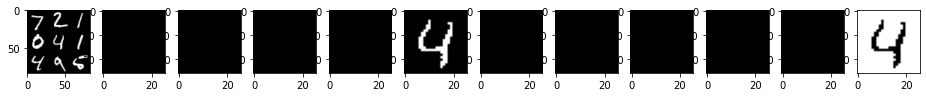

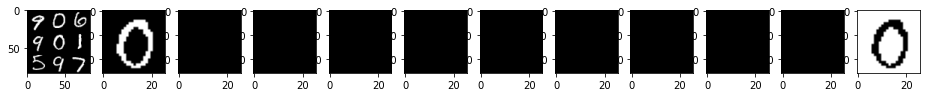

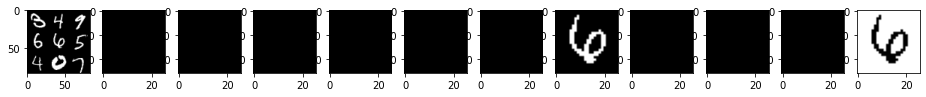

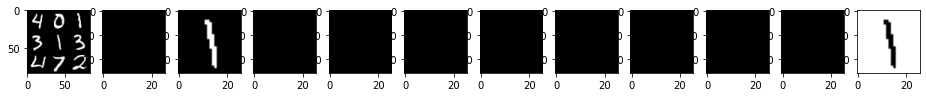

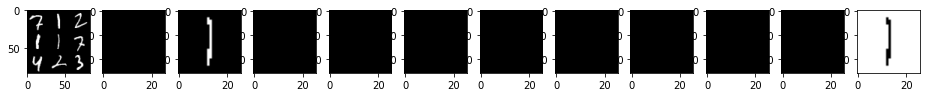

In [5]:
plt.figure(figsize=(16,8))
for source_imgs, teaching_imgs in loader_test:
    print(source_imgs[0].shape)
    print(teaching_imgs[0].shape)
    for i in range(min(mini_batch_size, 5)):
        plt_data(source_imgs[i], teaching_imgs[i])
    break

## ネットワーク構築

In [6]:
class SwitchModel(bb.Model):
    """モデル切り替え用基底クラス
    
      主に蒸留などでレイヤー差し替えに用いる

    Args:
        model_dict (int): 出力チャネル数
        hidden_ch (int): LUT-Net側の中間層チャネル数
        bin_dtype (DType): バイナリの型を bb.DType.FP32 と bb.DType.BIT から指定
    """
    
    def __init__(self, model_dict=None, init_model_name=None, *, input_shape=None, name=None):
        self.model_dict = model_dict
        self.current_model_name = None
        self.current_model = None
        super(SwitchModel, self).__init__(input_shape=input_shape, name=name)
        self.switch_model(init_model_name)
    
    def switch_model(self, model_name: str):
        """モデルを切り替える"""
        if self.model_dict is not None and model_name is not None:
            if model_name in self.model_dict:
                self.current_model_name = model_name
                self.current_model      = self.model_dict[model_name]
    
    def get_model_list(self):
        return self.model_dict.values()
    
    def get_current_model(self):
        return self.current_model

    def get_current_model_name(self):
        return self.current_model_name
    
    def get_core(self):
        current_model = self.get_current_model()
        if current_model is not None:
            return current_model.get_core()
        return None

    def get_info(self, depth :int=0, *, columns: int=70, nest: int=0) -> str:
        current_model = self.get_current_model()
        if current_model is not None:
            return current_model.get_info(depth=depth, columns=columns, nest=nest)
        return ''
    
    def send_command(self, command, send_to='all'):
        # 自分宛なら解釈
        if send_to == 'all' or send_to == self.get_name() or send_to == self.get_class_name():
            args = command.split()
            if len(args) == 2 and args[0] == 'switch_model':
                self.switch_model(args[1])
        
        # 子にも伝搬
        current_model = self.get_current_model()
        if current_model is not None:
            return current_model.send_command(command=command, send_to=send_to)

    def set_input_shape(self, input_shape: [int]):
        output_shape = None
        for name in self.model_dict:
            shape = self.model_dict[name].set_input_shape(input_shape)
            assert(output_shape is None or shape == output_shape) # すべて同じでなければNG
            output_shape = shape
        return output_shape
    
    def get_input_shape(self) -> [int]:
        return self.get_current_model().get_input_shape()

    def get_output_shape(self) -> [int]:
        return self.get_current_model().get_output_shape()

    def get_input_node_size(self) -> int:
        return self.get_current_model().get_input_node_size()

    def get_output_node_size(self) -> int:
        return self.get_current_model().get_output_node_size()

    def get_parameters(self):
        return self.get_current_model().get_parameters()

    def get_gradients(self):
        return self.get_current_model().get_gradients()

    def forward(self, x_buf, train=True):
        return self.get_current_model().forward(x_buf=x_buf, train=train)
    
    def backward(self, dy_buf):
        return self.get_current_model().backward(dy_buf=dy_buf)
    
    def dump_bytes(self):
        bytes_dict = {}
        for name in self.model_dict:
            bytes_dict[name] = self.model_dict[name].dump_bytes()
        return pickle.dumps(bytes_dict)
        
    def load_bytes(self, data):
        bytes_dict = pickle.loads(data)
        for name in self.model_dict:
            if name in bytes_dict:
                self.model_dict[name].load_bytes(bytes_dict[name])            

In [7]:
# バイナリ時は BIT型を使えばメモリ削減可能
bin_dtype = bb.DType.BIT if bin_mode else bb.DType.FP32

class DistillationConv(SwitchModel):
    """蒸留用クラス

    Args:
        output_ch (int): 出力チャネル数
        hidden_ch (int): LUT-Net側の中間層チャネル数
        bin_dtype (DType): バイナリの型を bb.DType.FP32 と bb.DType.BIT から指定
    """
    
    def __init__(self, hidden_ch, output_ch, stage, *, filter_size=(3,3), padding='valid', input_shape=None, bin_dtype=bb.DType.FP32):
        name = 'DistillationConv_%d' % stage
        # Dense
        self.dense_conv = bb.Convolution2d(
               bb.Sequential([
                   bb.DenseAffine([output_ch], name='dense_affine_%d' % stage),
                   bb.BatchNormalization(name='dense_bn_%d' % stage),
                   bb.ReLU(name='dense_act_%d' % stage, bin_dtype=bin_dtype),
               ]),
               filter_size=filter_size,
               padding=padding,
               name='dense_conv_%d' % stage,
               fw_dtype=bin_dtype)
        
        # LUT
        self.lut_conv = bb.Sequential([
                # pointwise
                bb.Convolution2d(
                   bb.Sequential([
                       bb.DifferentiableLut([hidden_ch*6, 1, 1], connection='random', name='lut_conv0_lut0_%d' % stage, bin_dtype=bin_dtype),
                       bb.DifferentiableLut([hidden_ch,   1, 1], connection='serial', name='lut_conv0_lut1_%d' % stage, bin_dtype=bin_dtype),
                   ]),
                   filter_size=(1, 1),
                   name='lut_conv0_%d' % stage,
                   fw_dtype=bin_dtype),
            
                # depthwise
                bb.Convolution2d(
                   bb.Sequential([
                       bb.DifferentiableLut([hidden_ch, 1, 1], connection='depthwise', name='lut_conv1_hidden0_%d' % stage, bin_dtype=bin_dtype),
                   ]),
                   filter_size=filter_size,
                   padding=padding,
                   name='lut_conv1_%d' % stage,
                   fw_dtype=bin_dtype),

                # pointwise
                bb.Convolution2d(
                   bb.Sequential([
                       bb.DifferentiableLut([output_ch*6, 1, 1], connection='random', name='lut_conv2_input0_%d' % stage, bin_dtype=bin_dtype),
                       bb.DifferentiableLut([output_ch,   1, 1], connection='serial', name='lut_conv2_input1_%d' % stage, bin_dtype=bin_dtype),
                   ]),
                   filter_size=(1, 1),
                   name='lut_conv2_%d' % stage,
                   fw_dtype=bin_dtype),
            ])
                
        model_dict = {}
        model_dict['dense'] = self.dense_conv
        model_dict['lut'] = self.lut_conv
        
        super(DistillationConv, self).__init__(model_dict=model_dict, init_model_name='dense', input_shape=input_shape, name=name)
        

sub_net = bb.Sequential()
for i in range(27):
    if i < 8:
        sub_net.append(DistillationConv(36*2, 36, stage=i, bin_dtype=bin_dtype))
    else:
        sub_net.append(DistillationConv(72*2, 72, stage=i, bin_dtype=bin_dtype))
        
sub_net.append(
        bb.Convolution2d(
            bb.Sequential([
                bb.DenseAffine([512], name='dense_affine_fc0'),
                bb.BatchNormalization(name='dense_bn_fc0'),
                bb.ReLU(bin_dtype=bin_dtype, name='dense_act_fc0'),
                bb.DenseAffine([11], name='dense_affine_fc1'),
                bb.BatchNormalization(name='dense_bn_fc1'),
                bb.ReLU(bin_dtype=bin_dtype, name='dense_act_fc1'),
            ]),
            filter_size=(5, 5),
            name='dense_conv_fc',
            fw_dtype=bin_dtype))
    
# define network
if bin_mode:
    net = bb.Sequential([
                bb.RealToBinary(frame_modulation_size=frame_modulation_size, bin_dtype=bin_dtype),
                sub_net,
                bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
            ])
else:
    net = sub_net
    
net.set_input_shape([1, rows*28, cols*28])

net.set_name(net_name)

if bin_mode:
    net.send_command("binary true")

print(net.get_info(1))

----------------------------------------------------------------------
[Sequential] MnistSegmentationDistillation
 input  shape : {1, 84, 84} output shape : {11, 26, 26}
----------------------------------------------------------------------



## 学習実施

学習を行います

In [8]:
def view(net, loader):
    num = 0;
    for x_imgs, t_imgs in loader:
        plt.figure(figsize=(16,8))
        x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
        t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))
        y_buf = net.forward(x_buf, train=False)
        result_imgs = y_buf.numpy()
        plt_data(x_imgs[0], result_imgs[0])
        num += 1
        if num >= 2: break

In [9]:
def learning(epochs=2):
    # learning
    loss      = bb.LossSoftmaxCrossEntropy() # MyLoss(loss_weight) # 
    #loss      = bb.LossMeanSquaredError()
    metrics   = bb.MetricsCategoricalAccuracy()
    optimizer = bb.OptimizerAdam()

    optimizer.set_variables(net.get_parameters(), net.get_gradients())

    for epoch in range(epochs):
#       view(net, loader_test)

        # learning
        loss.clear()
        metrics.clear()
        with tqdm(loader_train) as tqdm_loadr:
            for x_imgs, t_imgs in tqdm_loadr:
                x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
                t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))

                y_buf = net.forward(x_buf, train=True)

                dy_buf = loss.calculate(y_buf, t_buf)
                metrics.calculate(y_buf, t_buf)

                net.backward(dy_buf)

                optimizer.update()

                tqdm_loadr.set_postfix(loss=loss.get(), acc=metrics.get())

        # test
        loss.clear()
        metrics.clear()
        for x_imgs, t_imgs in loader_test:
            x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
            t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))

            y_buf = net.forward(x_buf, train=False)

            loss.calculate(y_buf, t_buf)
            metrics.calculate(y_buf, t_buf)

        bb.save_networks(data_path, net, keep_olds=3, force_flatten=True)

        print('epoch[%d] : loss=%f acc=%f' % (epoch, loss.get(), metrics.get()))

In [10]:
bb.load_networks(data_path, net, read_layers=True, force_flatten=True)
## bb.load_networks(data_path, net, read_layers=False, force_flatten=True)

load : ./data/MnistSegmentationDistillation\20210106_185107


In [11]:
import pickle
with open(os.path.join(data_path, 'hoge.bin'), 'wb') as f:
    pickle.dump(net, f)

In [12]:
import pickle
with open(os.path.join(data_path, 'hoge.bin'), 'rb') as f:
    net = pickle.load(f)
sub_net = net[1]

<Figure size 1152x576 with 0 Axes>

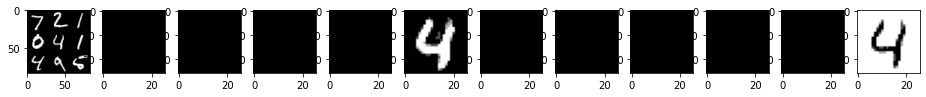

<Figure size 1152x576 with 0 Axes>

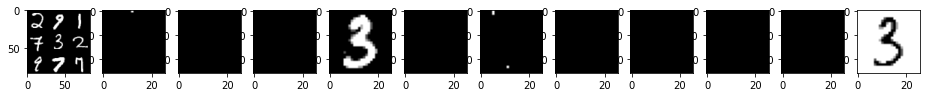

In [13]:
# DenseAffine で学習
#learning(32)
learning(0)
view(net, loader_test)

In [14]:
# bb.save_networks(data_path, net, keep_olds=3, write_layers=True, force_flatten=True)

----- layer 0 -----


<Figure size 1152x576 with 0 Axes>

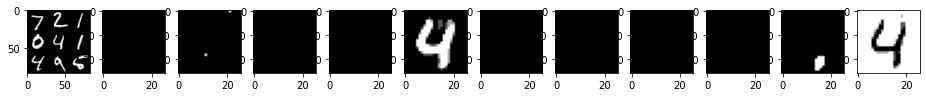

<Figure size 1152x576 with 0 Axes>

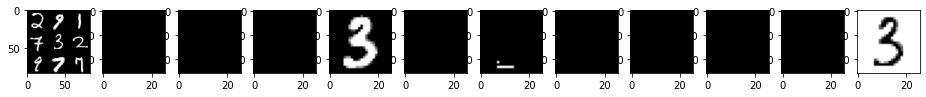

----- layer 1 -----


<Figure size 1152x576 with 0 Axes>

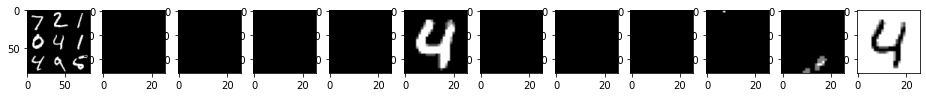

<Figure size 1152x576 with 0 Axes>

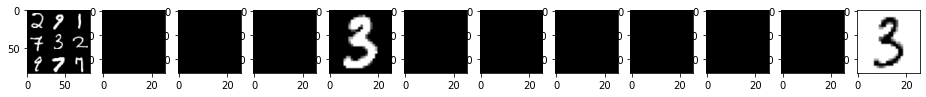

----- layer 2 -----


<Figure size 1152x576 with 0 Axes>

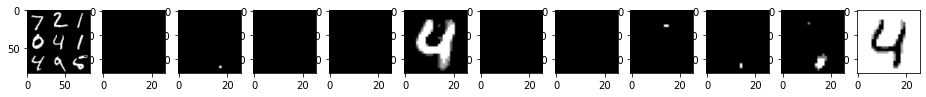

<Figure size 1152x576 with 0 Axes>

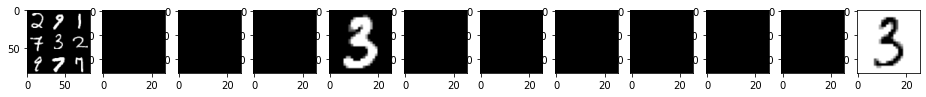

----- layer 3 -----


<Figure size 1152x576 with 0 Axes>

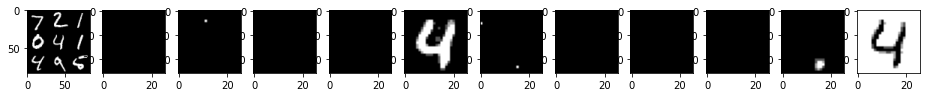

<Figure size 1152x576 with 0 Axes>

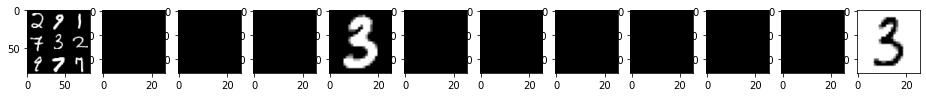

----- layer 4 -----


<Figure size 1152x576 with 0 Axes>

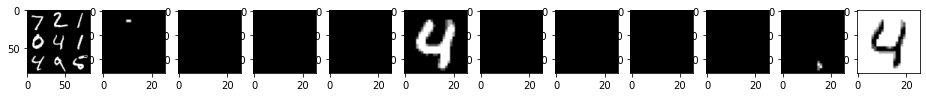

<Figure size 1152x576 with 0 Axes>

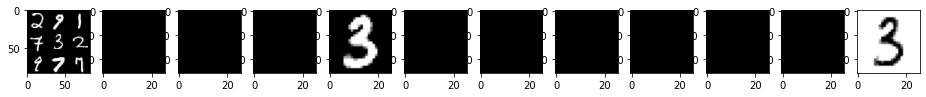

----- layer 5 -----


<Figure size 1152x576 with 0 Axes>

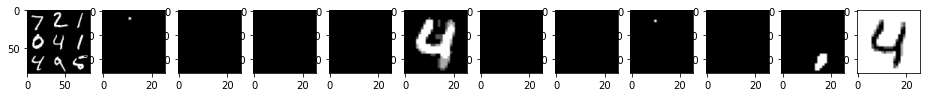

<Figure size 1152x576 with 0 Axes>

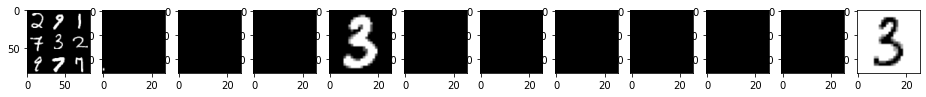

----- layer 6 -----


<Figure size 1152x576 with 0 Axes>

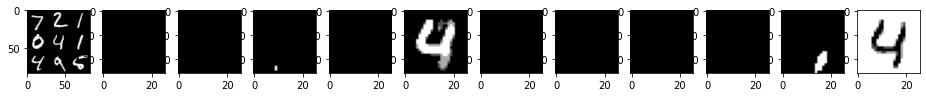

<Figure size 1152x576 with 0 Axes>

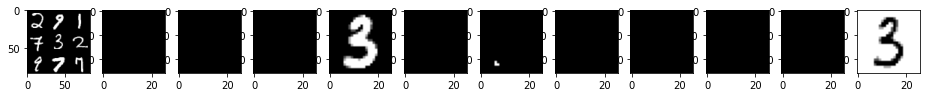

----- layer 7 -----


<Figure size 1152x576 with 0 Axes>

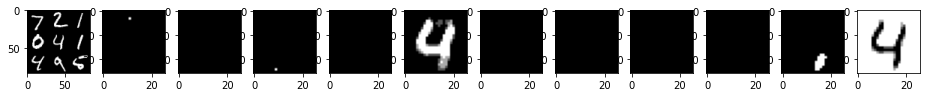

<Figure size 1152x576 with 0 Axes>

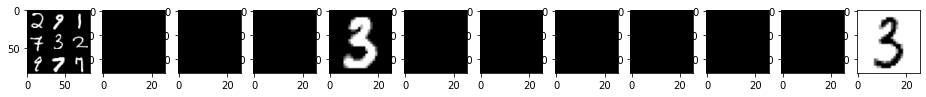

----- layer 8 -----


<Figure size 1152x576 with 0 Axes>

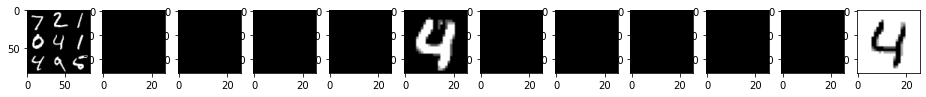

<Figure size 1152x576 with 0 Axes>

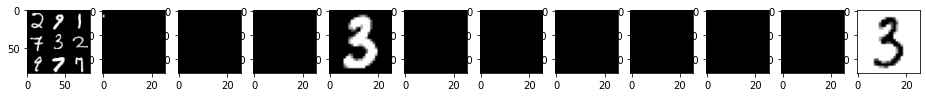

----- layer 9 -----


<Figure size 1152x576 with 0 Axes>

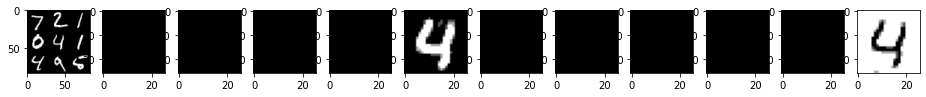

<Figure size 1152x576 with 0 Axes>

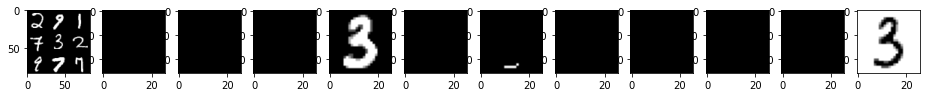

----- layer 10 -----


<Figure size 1152x576 with 0 Axes>

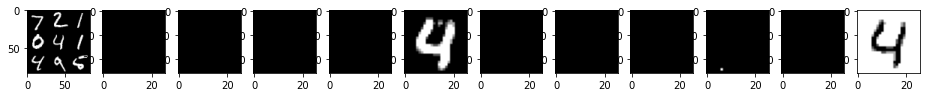

<Figure size 1152x576 with 0 Axes>

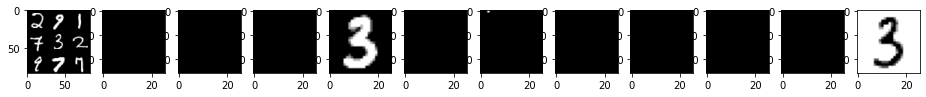

----- layer 11 -----


<Figure size 1152x576 with 0 Axes>

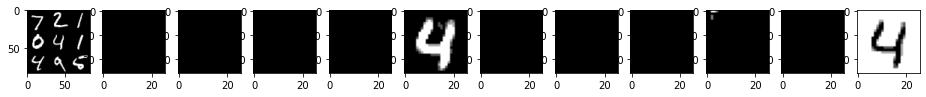

<Figure size 1152x576 with 0 Axes>

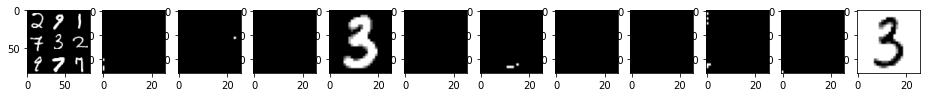

----- layer 12 -----


<Figure size 1152x576 with 0 Axes>

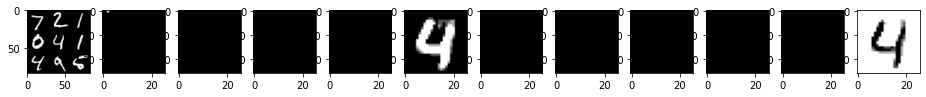

<Figure size 1152x576 with 0 Axes>

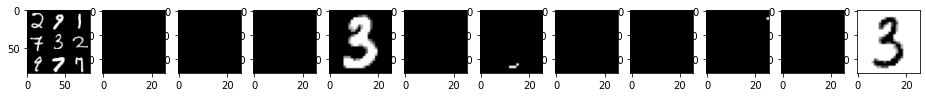

----- layer 13 -----


<Figure size 1152x576 with 0 Axes>

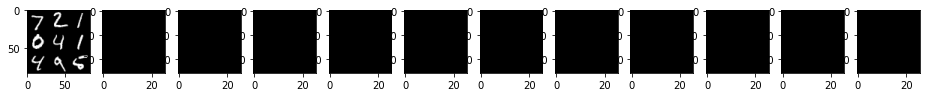

<Figure size 1152x576 with 0 Axes>

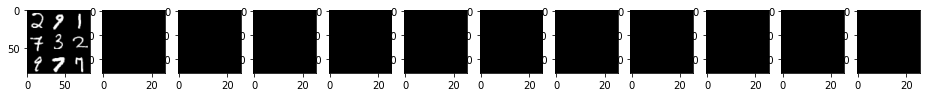

----- layer 14 -----


<Figure size 1152x576 with 0 Axes>

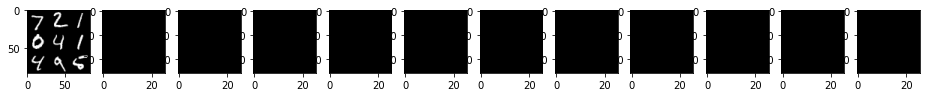

<Figure size 1152x576 with 0 Axes>

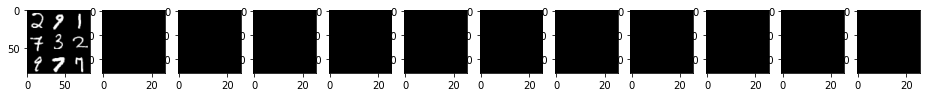

----- layer 15 -----


<Figure size 1152x576 with 0 Axes>

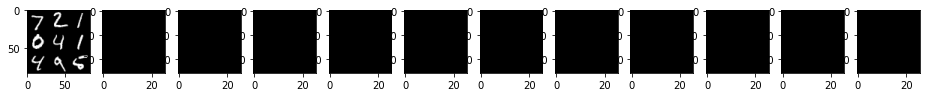

<Figure size 1152x576 with 0 Axes>

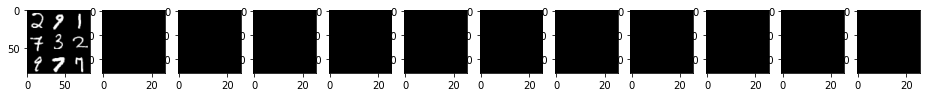

----- layer 16 -----


<Figure size 1152x576 with 0 Axes>

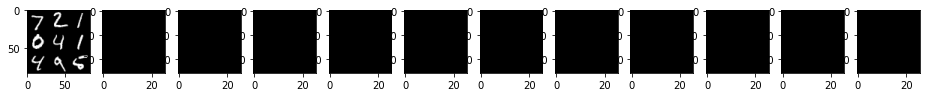

<Figure size 1152x576 with 0 Axes>

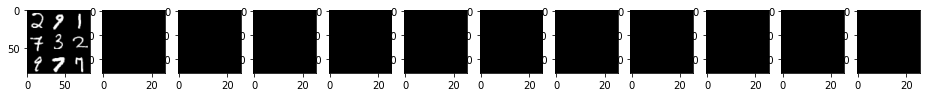

----- layer 17 -----


<Figure size 1152x576 with 0 Axes>

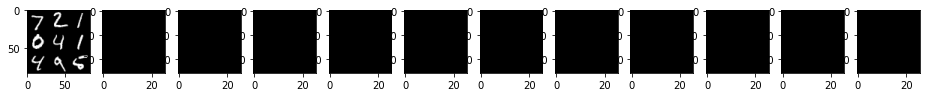

<Figure size 1152x576 with 0 Axes>

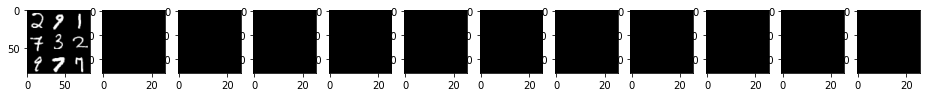

----- layer 18 -----


<Figure size 1152x576 with 0 Axes>

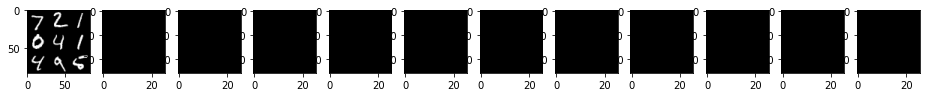

<Figure size 1152x576 with 0 Axes>

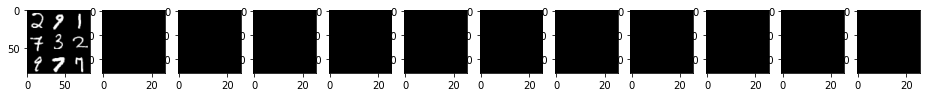

----- layer 19 -----


<Figure size 1152x576 with 0 Axes>

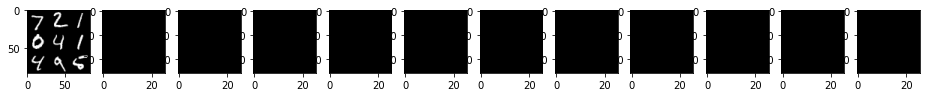

<Figure size 1152x576 with 0 Axes>

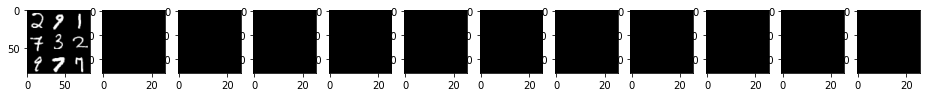

----- layer 20 -----


<Figure size 1152x576 with 0 Axes>

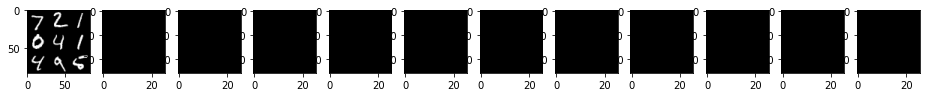

<Figure size 1152x576 with 0 Axes>

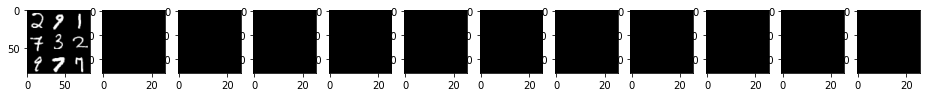

----- layer 21 -----


<Figure size 1152x576 with 0 Axes>

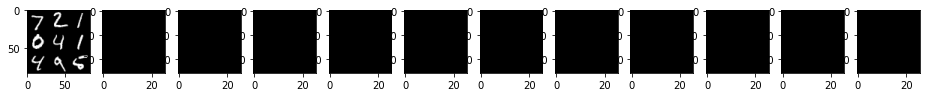

<Figure size 1152x576 with 0 Axes>

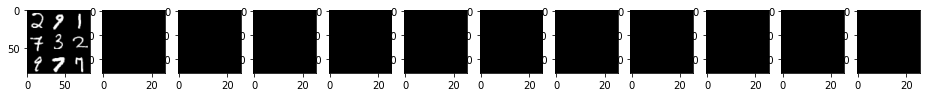

----- layer 22 -----


<Figure size 1152x576 with 0 Axes>

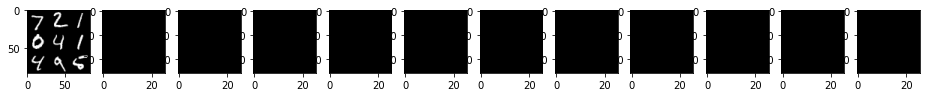

<Figure size 1152x576 with 0 Axes>

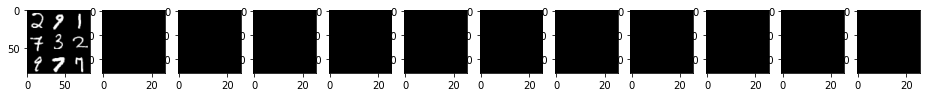

----- layer 23 -----


<Figure size 1152x576 with 0 Axes>

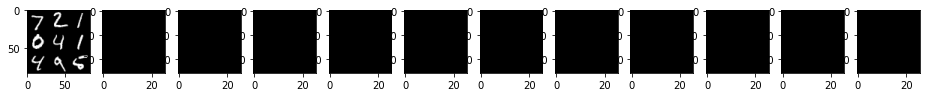

<Figure size 1152x576 with 0 Axes>

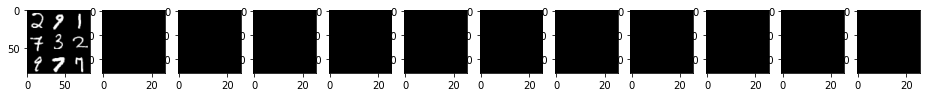

----- layer 24 -----


<Figure size 1152x576 with 0 Axes>

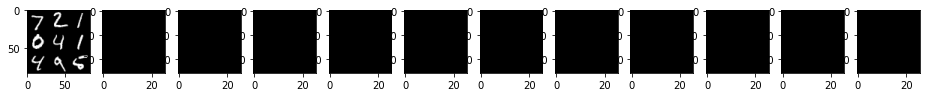

<Figure size 1152x576 with 0 Axes>

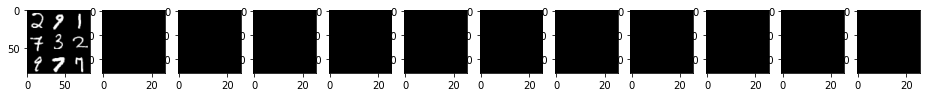

----- layer 25 -----


<Figure size 1152x576 with 0 Axes>

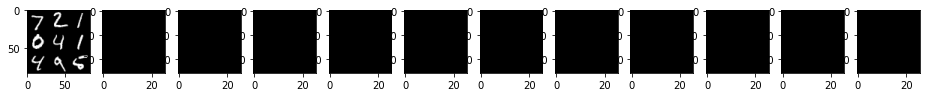

<Figure size 1152x576 with 0 Axes>

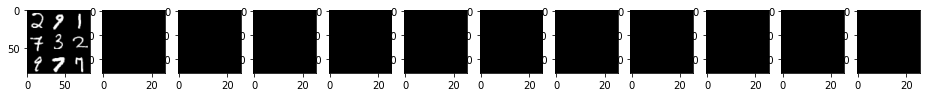

----- layer 26 -----


<Figure size 1152x576 with 0 Axes>

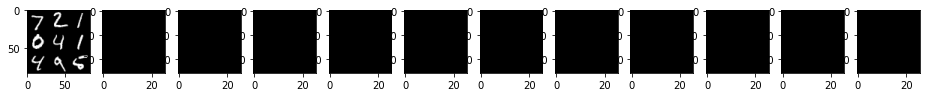

<Figure size 1152x576 with 0 Axes>

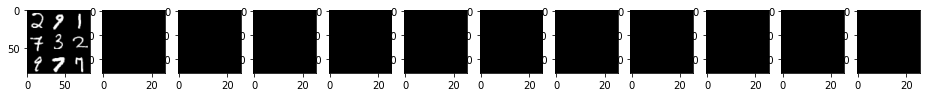

In [15]:
# 下の層から順に切り替えて表示
for i in range(27):
    print("----- layer %d -----"%i)
    sub_net[i].send_command('switch_model lut')
    net.send_command('parameter_lock true')
    sub_net[i].send_command('parameter_lock false')
#   learning(epochs=2)
    view(net, loader_test)

In [16]:
----------------

SyntaxError: invalid syntax (<ipython-input-16-0128abb360e6>, line 1)

In [ ]:
# 下の層から順に蒸留
for i in range(27):
    sub_net[i].send_command('switch_model lut')
    net.send_command('parameter_lock true')
    sub_net[i].send_command('parameter_lock false')
    learning(epochs=2)
    view(net, loader_test)